Monta o Google Drive para ter acesso ao Dataset

O dataset está disponível em: [dataset_animais.tgz](https://drive.google.com/uc?id=1htigpGnfmJHWbCwVt1AM_1Ral32h22YI&export=download&confirm=t&uuid=e8dfdb19-fb74-42b8-9b07-385ba9abeff7)

Salve o dataset em uma pasta chamada "datasets"

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Extração do dataset via Google Drive

In [ ]:
#! tar -xf '/content/drive/MyDrive/datasets/dataset_animais.tgz'

Faz o download automaticamente direto do Google Drive e salva como "dataset_animais.tgz"

In [ ]:
! wget -O 'dataset_animais.tgz' 'https://drive.google.com/uc?id=1htigpGnfmJHWbCwVt1AM_1Ral32h22YI&export=download&confirm=t&uuid=e8dfdb19-fb74-42b8-9b07-385ba9abeff7'

--2022-11-25 13:43:13--  https://drive.google.com/uc?id=1htigpGnfmJHWbCwVt1AM_1Ral32h22YI&export=download&confirm=t&uuid=e8dfdb19-fb74-42b8-9b07-385ba9abeff7
Resolving drive.google.com (drive.google.com)... 142.251.12.139, 142.251.12.101, 142.251.12.138, ...
Connecting to drive.google.com (drive.google.com)|142.251.12.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hdaej57msbpqe1i07odsopco088bbo4o/1669383750000/03713128669812995390/*/1htigpGnfmJHWbCwVt1AM_1Ral32h22YI?e=download&uuid=e8dfdb19-fb74-42b8-9b07-385ba9abeff7 [following]
--2022-11-25 13:43:14--  https://doc-0o-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hdaej57msbpqe1i07odsopco088bbo4o/1669383750000/03713128669812995390/*/1htigpGnfmJHWbCwVt1AM_1Ral32h22YI?e=download&uuid=e8dfdb19-fb74-42b8-9b07-385ba9abeff7
Resolving doc-0o-54-docs.googleusercontent.com (doc-0o-54-

In [ ]:
! tar -xf '/content/dataset_animais.tgz'

In [ ]:
data_dir = '/content/archive'
images_dir = '/content/archive/images'

In [ ]:
# Imports here
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

## Carregamento dos dados

Para carregar os dados foi criada uma classe baseada na classe padrão "ImageFolder" do torchvision. Assim será possível armazenar o caminho para o arquivo no dataset.


Após o carregamento o dataset é dividido em três partes, sendo: treino, validação e teste.

Para cada dataset também são aplciadas transformações nas imagens a fim de diminuir o tamanho para poupar memória e agilizar os cálculos.

Será usado um modelo pré-treinado. As definições do modelo exigem que seja feita uma normalização.

In [ ]:
class ImageFolderWithPaths(datasets.ImageFolder):
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [ ]:
# Define as transformações usadas nas imagens
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

# Carrega o dataset
full_dataset = ImageFolderWithPaths(images_dir, transform=training_transforms)

# Controle de desenvolvimento para carregar menos dados
dev = True
dev_prop = 0.05 if dev else 1

# Pondera o tamanho do dataset para uma porcentagem definida acima
sub_dataset, trash = torch.utils.data.random_split(full_dataset, (round(dev_prop*len(full_dataset)), round((1-dev_prop)*len(full_dataset))))

# Divide o data set em 3 para treino, validação e teste
# Na proporção de 60%, 20%, 20%
train_dataset, validate_dataset, test_dataset = torch.utils.data.random_split(sub_dataset, (round(
    0.6*len(sub_dataset)), round(0.2*len(sub_dataset)), round(0.2*len(sub_dataset))))

# Define os dadaloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validate_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

print('# Tamanho ponderado do dataset #')
print(len(train_dataset))
print(len(validate_dataset))
print(len(test_dataset))

# Tamanho ponderado do dataset #
785
262
262


### Rótulos

Carrega um arquivo com os rótulos para as imagens.

In [ ]:
import json

with open('/content/archive/class_to_name.json', 'r') as f:
    class_to_name = json.load(f)
    
print(len(class_to_name)) 
print(class_to_name)

10
{'1': 'cachorro', '2': 'cavalo', '3': 'elefante', '4': 'borboleta', '5': 'galinha', '6': 'gato', '7': 'boi', '8': 'ovelha', '9': 'aranha', '10': 'esquilo'}


# Classificador

Carrega [um modelo pré treinado](https://pytorch.org/vision/stable/models.html) disponível nos pacotes do PyTorch

In [ ]:
# Build and train your network
# Transfer Learning
model = models.vgg16(pretrained=True)
model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Por ser uma rede pré treinada, não é necessário aplicar o backpropagation
for parameter in model.parameters():
    parameter.requires_grad = False


from collections import OrderedDict

# Define o classificador a ser usado no modelo
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 5000)),
                                        ('relu', nn.ReLU()),
                                        ('drop', nn.Dropout(p=0.5)),
                                        ('fc2', nn.Linear(5000, 102)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier

In [ ]:
# Função de validação
def validation(model, validateloader, criterion):
    
    val_loss = 0
    accuracy = 0
    
    for images, labels, _ in iter(validateloader):

        images, labels = images.to('cuda'), labels.to('cuda')

        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)
        
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return val_loss, accuracy

In [ ]:
# Funções de perda e otimização
criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [ ]:
evolution = []
# Função de treino
def train_classifier():
      epochs = 50
      steps = 0
      print_every = 5

      model.to('cuda')

      for e in range(epochs):
      
          model.train()
  
          running_loss = 0
  
          for images, labels, _ in iter(train_loader):
      
              steps += 1
      
              images, labels = images.to('cuda'), labels.to('cuda')
      
              optimizer.zero_grad()
      
              output = model.forward(images)
              loss = criterion(output, labels)
              loss.backward()
              optimizer.step()
      
              running_loss += loss.item()

              # Muda o modelo para o modo de validação
              model.eval()
              validation_loss, accuracy = validation(model, validate_loader, criterion)

              evolution.append((running_loss, validation_loss, accuracy))
      
              if steps % print_every == 0:
      
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Loss de treino: {:.3f}.. ".format(running_loss/print_every),
                      "Loss de validação: {:.3f}.. ".format(validation_loss/len(validate_loader)),
                      "Taxa de acerto: {:.3f}".format(accuracy/len(validate_loader)))
        
                running_loss = 0
                # Volta o modelo para o modo de treino
                model.train()
                    
train_classifier()                    

Epoch: 1/50..  Loss de treino: 20.105..  Loss de validação: 16.301..  Taxa de acerto: 0.247
Epoch: 1/50..  Loss de treino: 11.083..  Loss de validação: 2.774..  Taxa de acerto: 0.455
Epoch: 2/50..  Loss de treino: 0.782..  Loss de validação: 1.936..  Taxa de acerto: 0.520
Epoch: 2/50..  Loss de treino: 1.261..  Loss de validação: 1.024..  Taxa de acerto: 0.671
Epoch: 2/50..  Loss de treino: 0.908..  Loss de validação: 1.008..  Taxa de acerto: 0.682
Epoch: 3/50..  Loss de treino: 0.539..  Loss de validação: 0.930..  Taxa de acerto: 0.696
Epoch: 3/50..  Loss de treino: 0.662..  Loss de validação: 0.776..  Taxa de acerto: 0.731
Epoch: 4/50..  Loss de treino: 0.106..  Loss de validação: 0.700..  Taxa de acerto: 0.755
Epoch: 4/50..  Loss de treino: 0.517..  Loss de validação: 0.812..  Taxa de acerto: 0.737
Epoch: 4/50..  Loss de treino: 0.511..  Loss de validação: 0.886..  Taxa de acerto: 0.731
Epoch: 5/50..  Loss de treino: 0.264..  Loss de validação: 0.771..  Taxa de acerto: 0.723
Epoch: 

In [ ]:
def train_classifier():

    #with active_session():

    epochs = 7
    steps = 0
    print_every = 1

    model.to('cuda')

    for e in range(epochs):
    
        model.train()

        running_loss = 0

        for images, labels, _ in iter(train_loader):
    
            steps += 1
    
            images, labels = images.to('cuda'), labels.to('cuda')
    
            optimizer.zero_grad()
    
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
    
            if steps % print_every == 0:
            
                model.eval()
            
                # Turn off gradients for validation, saves memory and computations
                with torch.no_grad():
                    validation_loss, accuracy = validation(model, validate_loader, criterion)
        
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Validation Loss: {:.3f}.. ".format(validation_loss/len(validate_loader)),
                      "Validation Accuracy: {:.3f}".format(accuracy/len(validate_loader)))
        
                running_loss = 0
                model.train()
                    
train_classifier()

Epoch: 1/7..  Training Loss: 0.202..  Validation Loss: 0.657..  Validation Accuracy: 0.788
Epoch: 1/7..  Training Loss: 0.237..  Validation Loss: 0.830..  Validation Accuracy: 0.801
Epoch: 1/7..  Training Loss: 0.415..  Validation Loss: 0.913..  Validation Accuracy: 0.762
Epoch: 1/7..  Training Loss: 0.115..  Validation Loss: 0.892..  Validation Accuracy: 0.801
Epoch: 1/7..  Training Loss: 0.560..  Validation Loss: 0.697..  Validation Accuracy: 0.806
Epoch: 1/7..  Training Loss: 0.173..  Validation Loss: 0.826..  Validation Accuracy: 0.806
Epoch: 1/7..  Training Loss: 0.395..  Validation Loss: 0.823..  Validation Accuracy: 0.787
Epoch: 1/7..  Training Loss: 0.411..  Validation Loss: 0.948..  Validation Accuracy: 0.772
Epoch: 1/7..  Training Loss: 0.274..  Validation Loss: 0.772..  Validation Accuracy: 0.823
Epoch: 1/7..  Training Loss: 0.364..  Validation Loss: 0.901..  Validation Accuracy: 0.781
Epoch: 1/7..  Training Loss: 0.399..  Validation Loss: 0.666..  Validation Accuracy: 0.812

# Gráfico de convergência

Apresenta um gráfico com a evolução do treinamento do modelo

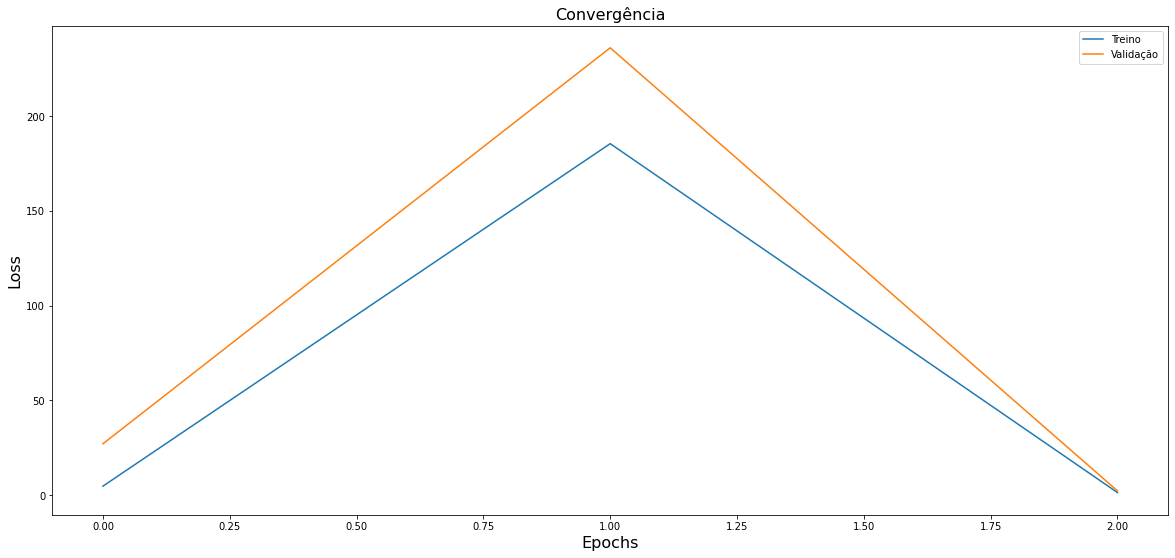

In [ ]:
plt.figure(figsize=(20, 9))
plt.plot(evolution[0], label='Treino')
plt.plot(evolution[1], label='Validação')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergência', fontsize=16)
plt.legend()
plt.show()

## Testando o modelo

In [ ]:
def test_accuracy(model, test_loader):

    model.eval()
    model.to('cuda')

    with torch.no_grad():    
        accuracy = 0
    
        for images, labels, _ in iter(test_loader):
            images, labels = images.to('cuda'), labels.to('cuda')
            output = model.forward(images)
            probabilities = torch.exp(output)
            equality = (labels.data == probabilities.max(dim=1)[1])
            accuracy += equality.type(torch.FloatTensor).mean()
        
        print("Taxa de acerto: {}".format(accuracy/len(test_loader)))    
        
        
test_accuracy(model, test_loader)

Taxa de acerto: 0.8020833134651184


In [ ]:
# Salva o modelo

def save_checkpoint(model):

    # Salva uma transposição dos índices de classes do dataset
    model.class_to_idx = full_dataset.class_to_idx

    checkpoint = {'arch': "vgg16",
                  'class_to_idx': model.class_to_idx,
                  'model_state_dict': model.state_dict()
                 }

    torch.save(checkpoint, 'checkpoint.pth')
    
save_checkpoint(model)    

In [ ]:
from collections import OrderedDict

# Carrega o modelo

def load_checkpoint(filepath):
    
    checkpoint = torch.load(filepath)
    
    if checkpoint['arch'] == 'vgg16':
        
        model = models.vgg16(pretrained=True)
        
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Não foi possível carregar o modelo")
    
    model.class_to_idx = checkpoint['class_to_idx']
    
    classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 5000)),
                                            ('relu', nn.ReLU()),
                                            ('drop', nn.Dropout(p=0.5)),
                                            ('fc2', nn.Linear(5000, 102)),
                                            ('output', nn.LogSoftmax(dim=1))]))

    model.classifier = classifier
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model


## Processamento de imagem

Função para processar as imagens de forma a satisfazer o padrão usado no modelo

In [ ]:
from PIL import Image

def process_image(image_path):      
    pil_image = Image.open(image_path)
    
    # Redimensionamento
    if pil_image.size[0] > pil_image.size[1]:
        pil_image.thumbnail((5000, 256))
    else:
        pil_image.thumbnail((256, 5000))
        
    # Corte
    left_margin = (pil_image.width-224)/2
    bottom_margin = (pil_image.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    # Normaliza de acordo com o ImageNet
    np_image = np.array(pil_image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # Muda a posição do canal de cores, pois o ImageNet e o pytorch usam o canal em posições diferentes
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

# Imagem Aleatória

Função que retorna uma imagem aleatória do dataset completo

In [ ]:
def randomImage():
  pos = random.randint(0,len(full_dataset)-1)
  path = full_dataset[pos][2]
  return path


# Exibe imagem

Função para exibir as imagens, convertendo de volta de Tensor

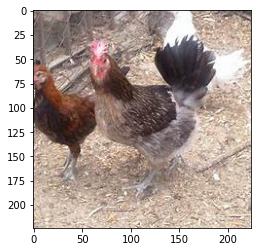

In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # Reposiciona o canal de cor para o padrão matplot
    image = image.transpose((1, 2, 0))
    
    # Desfaz a normalização
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    if title is not None:
        ax.set_title(title)
    
    # Corte da imagem
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

image = process_image(randomImage())
imshow(image)

## Previsões

Calcula a probabilidade de cada classe para a imagem fornecida.

Retorna as 5 maiores probabilidades

In [ ]:
def predict(image_path, model, topk=5):    
    image = process_image(image_path)
    
    # Converte a imagem para um tensor
    image = torch.from_numpy(image).type(torch.cuda.FloatTensor)
    image = image.unsqueeze(0)
    
    output = model.forward(image)
    
    probabilities = torch.exp(output)
    
    # Retorna as classes com maior probabilidade para a imagem
    top_probabilities, top_indices = probabilities.topk(topk)
    
    # Conversão para lista
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    
    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    
    top_classes = [idx_to_class[index] for index in top_indices]
    
    return top_probabilities, top_classes
    
probs, classes = predict(randomImage(), model)   
print(probs)
print(classes)

[0.9999998807907104, 5.112979550858654e-08, 4.342873438645256e-08, 2.850451608082949e-08, 8.380496296922502e-09]
['8', '7', '10', '5', '1']


## Validação visual

Aqui fazemos uma validação visual do da predição para termos certeza de que o
modelo está funcionando corretamente

In [ ]:
randomImage()

'/content/archive/images/2/OIP-uQ8Bm793M4EFI6hr8Ypj7gHaFc.jpeg'

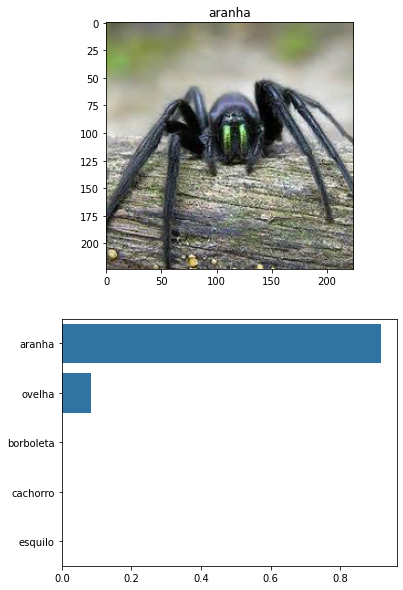

In [58]:
# Plota a imagem
plt.figure(figsize = (6,10))
plot_1 = plt.subplot(2,1,1)

img_link = randomImage()

probs, classes = predict(img_link, model)   

image = process_image(img_link)

title = class_to_name[classes[0]]

imshow(image, plot_1, title=title);

# Recupera o nome da classe
flower_names = [class_to_name[i] for i in classes]

# Plota a probabilidade para as 5 classes recuperadas
plt.subplot(2,1,2)

sb.barplot(x=probs, y=flower_names, color=sb.color_palette()[0]);

plt.show()